# Ensemble methods and Fairness
This notebook aims at presenting some basics on ensemble methods and, hopefully, fairness. It is inspired by [the Google Python notebook on fairness](https://colab.research.google.com/notebooks/mlcc/intro_to_fairness.ipynb) that you might consult.

## About the Dataset and Prediction Task

In this exercise, you'll work with the [Adult Census Income dataset](https://archive.ics.uci.edu/ml/datasets/Census+Income), which is commonly used in machine learning literature. This data was extracted from the [1994 Census bureau database](http://www.census.gov/en.html) by Ronny Kohavi and Barry Becker.

Each example in the dataset contains the following demographic data for a set of individuals who took part in the 1994 Census:

### Numeric Features
*   `age`: The age of the individual in years.
*   `fnlwgt`: The number of individuals the Census Organizations believes that set of observations represents.
*   `education_num`:  An enumeration of the categorical representation of education. The higher the number, the higher the education that individual achieved. For example, an `education_num` of `11` represents `Assoc_voc` (associate degree at a vocational school), an `education_num` of `13` represents `Bachelors`, and an `education_num` of `9` represents `HS-grad` (high school graduate).
*   `capital_gain`: Capital gain made by the individual, represented in US Dollars.
*   `capital_loss`: Capital loss mabe by the individual, represented in US Dollars.
*   `hours_per_week`: Hours worked per week.

### Categorical Features
*   `workclass`: The individual's type of employer. Examples include: `Private`, `Self-emp-not-inc`, `Self-emp-inc`, `Federal-gov`, `Local-gov`, `State-gov`, `Without-pay`, and `Never-worked`.
*   `education`: The highest level of education achieved for that individual.
*   `marital_status`: Marital status of the individual. Examples include: `Married-civ-spouse`, `Divorced`, `Never-married`, `Separated`, `Widowed`, `Married-spouse-absent`, and `Married-AF-spouse`.
*   `occupation`: The occupation of the individual. Example include: `tech-support`, `Craft-repair`, `Other-service`, `Sales`, `Exec-managerial` and more.
*   `relationship`:  The relationship of each individual in a household. Examples include: `Wife`, `Own-child`, `Husband`, `Not-in-family`, `Other-relative`, and `Unmarried`.
*   `gender`:  Gender of the individual available only in binary choices: `Female` or `Male`.
*   `race`: `White`, `Asian-Pac-Islander`, `Amer-Indian-Eskimo`, `Black`, and `Other`. 
*   `native_country`: Country of origin of the individual. Examples include: `United-States`, `Cambodia`, `England`, `Puerto-Rico`, `Canada`, `Germany`, `Outlying-US(Guam-USVI-etc)`, `India`, `Japan`, `United-States`, `Cambodia`, `England`, `Puerto-Rico`, `Canada`, `Germany`, `Outlying-US(Guam-USVI-etc)`, `India`, `Japan`, and more.

### Prediction Task
The prediction task is to **determine whether a person makes over $50,000 US Dollar a year.**

### Label
*   `income_bracket`: Whether the person makes more than $50,000 US Dollars annually.

### Notes on Data Collection

All the examples extracted for this dataset meet the following conditions: 
*   `age` is 16 years or older.
*   The adjusted gross income (used to calculate `income_bracket`) is greater than $100 USD annually.
*   `fnlwgt` is greater than 0.
*   `hours_per_week` is greater than 0.

## Setup

First, import some modules that will be used throughout this notebook.

In [1]:
import os

from itertools import product

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import sklearn.preprocessing as preprocessing

import pandas as pd
import tempfile
!pip install seaborn==0.8.1
import seaborn as sns
import itertools

from google.colab import widgets
# For facets
from IPython.core.display import display, HTML
import base64
!pip install facets-overview==1.0.0
from facets_overview.feature_statistics_generator import FeatureStatisticsGenerator

print('Modules are imported.')

Modules are imported.


### Load the Adult Dataset

With the modules now imported, we can load the Adult dataset into a pandas DataFrame data structure.

In [2]:
COLUMNS = ["age", "workclass", "fnlwgt", "education", "education_num",
           "marital_status", "occupation", "relationship", "race", "gender",
           "capital_gain", "capital_loss", "hours_per_week", "native_country",
           "income_bracket"]

train_df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=COLUMNS,
    sep=r'\s*,\s*',
    engine='python',
    na_values="?")
test_df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
    names=COLUMNS,
    sep=r'\s*,\s*',
    skiprows=[0],
    engine='python',
    na_values="?")

# Drop rows with missing values
train_df = train_df.dropna(how="any", axis=0)
test_df = test_df.dropna(how="any", axis=0)

print('UCI Adult Census Income dataset loaded.')

UCI Adult Census Income dataset loaded.


## Analyzing the Adult Dataset with Facets

To start, we can use [Facets Overview](https://pair-code.github.io/facets/), an interactive visualization tool that can help us explore the dataset. With Facets Overview, we can quickly analyze the distribution of values across the Adult dataset.

In [3]:
#@title Visualize the Data in Facets
fsg = FeatureStatisticsGenerator()
dataframes = [
    {'table': train_df, 'name': 'trainData'}]
censusProto = fsg.ProtoFromDataFrames(dataframes)
protostr = base64.b64encode(censusProto.SerializeToString()).decode("utf-8")


HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

We drop some irrelevant variables (mostly zero valued): 'capital_gain', 'capital_loss' and we try to select the best depth in our DT.

# Decision trees
We recall the properties of a Decision Tree below.

Decision trees, and in particular classification and regression trees (CART), are supervised estimators introduced by Leo Breiman et al.
The paradigm of a binary decision tree is to recursively split the space $\mathcal X$ with simple rules such that: is the explicative variable $x_j$ greater than the threshold $\tau$ or not?
Doing so, a decision tree is built, for which each node corresponds to a simple rule (and secondarly to a partition cell of $\mathcal X$).
The final result is a partition of $\mathcal X$ by hypercubes.

At each step of the learning algorithm, 

1. consider the partition $\mathcal P = \{\mathcal X\}$;
1. for each cell $\mathcal A$ of $\mathcal P$, define the two-cell partition
$\mathcal A = \mathcal L_{j, \tau} \cup \mathcal R_{j, \tau}$, where $j \in [d]$ is a feature index and $\tau \in \mathbb R$ is a threhold, and
$$
    \begin{cases}
        \mathcal L_{j, \tau} = \left\{ x \in \mathcal A :  x_j \le \tau \right\}\\
        \mathcal R_{j, \tau} = \left\{ x \in \mathcal A :  x_j > \tau \right\}
        %= \mathcal A \backslash \mathcal L_{j, \tau}.
    \end{cases}
$$
are the "left" and "right" parts of $\mathcal A$.
Then, find the best pair (feature, threhold) for splitting:
$$
    (j, \tau) \in \operatorname{arg\,min}_{1 \le j \le d \atop \tau \in \mathbb R}
    \frac{\left| \mathcal L_{j, \tau} \right|}{\left| \mathcal A \right|} D(\mathcal L_{j, \tau}) +
    \frac{\left| \mathcal R_{j, \tau} \right|}{\left| \mathcal A \right|} D(\mathcal R_{j, \tau})
$$
where $D$ is a distortion measure for a cell (see below);
1. replace $\mathcal A$ by $\mathcal L_{j, \tau}$ and $\mathcal R_{j, \tau}$ in the partition $\mathcal P$;
1. go to 2.

Given a cell $\mathcal A$, one may define the ratio of observations of $\mathcal A$ of class $y \in \mathcal Y$:
$$
    p_y(\mathcal A) = \frac{\left| \left\{ i \in [n] : X_i \in \mathcal A, Y_i=y \right\} \right|}{\left| \mathcal A \right|}.
$$

Then, the distortion of the cell $\mathcal A$ may be:
- Gini impurity: $D(\mathcal A) = \sum_{y \in \mathcal Y} p_y(\mathcal A) (1-p_y(\mathcal A))$ (classification);
- entropy: $D(\mathcal A) = - \sum_{y \in \mathcal Y} p_y(\mathcal A) \log(p_y(\mathcal A))$ (classification);
- mean squared error: $D(\mathcal A) = \frac{1}{\left| \mathcal A \right|}\sum_{1 \le i \le n \atop X_i \in \mathcal A} \left( Y_i - \bar Y_{\mathcal A} \right)^2$, with $\bar Y_{\mathcal A} = \frac{1}{\left| \mathcal A \right|}\sum_{1 \le i \le n \atop X_i \in \mathcal A} Y_i$ (regression).

For regression, Jerome Friedman suggested an improved criterion (in its original paper tackling gradient boosting), referred to as Friedman's mean squared error:
$$
    (j, \tau) \in \operatorname{arg\,min}_{1 \le j \le d \atop \tau \in \mathbb R}
    \frac{ \left| \mathcal L_{j, \tau} \right| \left| \mathcal R_{j, \tau} \right| }{ \left| \mathcal L_{j, \tau} \right| + \left| \mathcal R_{j, \tau} \right| }
    \left( \bar Y_{\mathcal L_{j, \tau}} - \bar Y_{\mathcal R_{j, \tau}} \right)^2.
$$

Last but not least, several stopping rules are of interests:
- maximal depth of the tree;
- minimal number of observations required to split an internal node;
- minimal number of observations required to be at a leaf node;
- maximal number of leaf nodes.

We would like to assess the accuracy of a [classification tree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) with respect to the kind of splitting criterion (Gini impurity or entropy) and to the maximal depth allowed.

Text(0.5, 1.0, 'Test accuracy DCT')

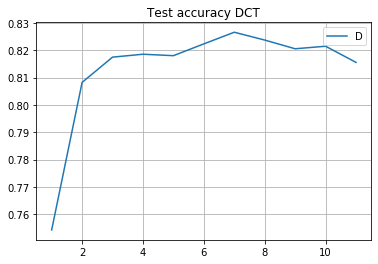

In [4]:
# prepare data
X_raw=train_df.drop(['income_bracket','capital_gain', 'capital_loss'], axis=1)
y=train_df['income_bracket'].apply(lambda x: ">50K" in x).astype(int)

X_test_raw=test_df.drop(['income_bracket','capital_gain', 'capital_loss'], axis=1)
y_test =test_df['income_bracket'].apply(lambda x: ">50K" in x).astype(int)

# Encode the categorical features as numbers
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders

X,encoders = number_encode_features(X_raw)

X_train = X.to_numpy()
y_train = y.to_numpy()

X_test,encoders_test = number_encode_features(X_test_raw)

X_test = X_test.to_numpy()
y_test = y_test.to_numpy()


# testing the parameters 
k_values = np.arange(1, 12)


# DTC
score = []
for k in k_values:
    clf = DecisionTreeClassifier(max_depth=k)
    clf.fit(X_train, y_train)
    score.append(clf.score(X_test, y_test))
    
plt.plot(k_values, score)
plt.grid()
plt.legend('DCT')
plt.title("Test accuracy DCT")

We check the train/test error

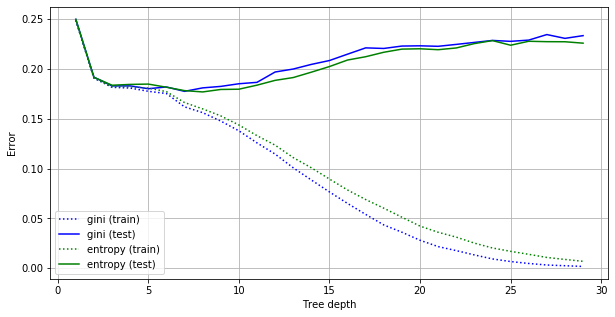

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)


depths = np.arange(1, 30)
criteria = ["gini", "entropy"]

train_err = []
test_err = []
for criterion in criteria:
    train_err.append([])  # New criteria => new list
    test_err.append([])
    for depth in depths:
        clf = DecisionTreeClassifier(criterion=criterion, max_depth=depth)
        clf.fit(X_train, y_train)
        train_err[-1].append(1-clf.score(X_train, y_train))
        test_err[-1].append(1-clf.score(X_test, y_test))
        
plt.figure(figsize=(10, 5))
colors = "bgrc"
for ic, criterion in enumerate(criteria):
    plt.plot(depths, train_err[ic], color=colors[ic], linestyle=':',
             label=criterion+" (train)")
    plt.plot(depths, test_err[ic], color=colors[ic], linestyle='-',
             label=criterion+" (test)")
plt.xlabel("Tree depth")
plt.ylabel("Error")
plt.grid()
plt.legend(loc="best")

Well, depth = 7 seems a good choice!

We check also with CV

In [6]:
from sklearn.model_selection import cross_val_score

# Answer
score = []
for k in k_values:
    clf = DecisionTreeClassifier(max_depth=k)
    score.append(cross_val_score(clf, X_train, y_train).mean())
    
ik = np.argmax(score)
n_neighbors = k_values[ik]
clf = DecisionTreeClassifier(max_depth=n_neighbors)
clf.fit(X_train, y_train)

print("Depth:", n_neighbors)
print("Crossval score:", score[ik])
print("Test accuracy:", clf.score(X_test, y_test))

Depth: 7
Crossval score: 0.8222907796329684
Test accuracy: 0.8222958972233734


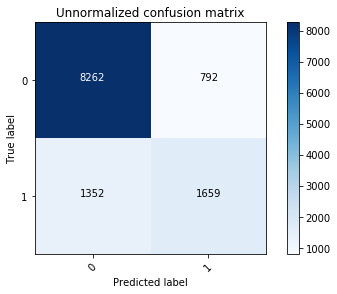

In [7]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_pred, y, classes=None, normalize=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    title='Confusion matrix'
    cmap=plt.cm.Blues
    
    cm = confusion_matrix(y, y_pred)
    
    if classes is None:
        classes = np.unique(y)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized confusion matrix'
    else:
        title = 'Unnormalized confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_pred = clf.predict(X_test)
plot_confusion_matrix(y_pred, y_test)

And we plot de DT

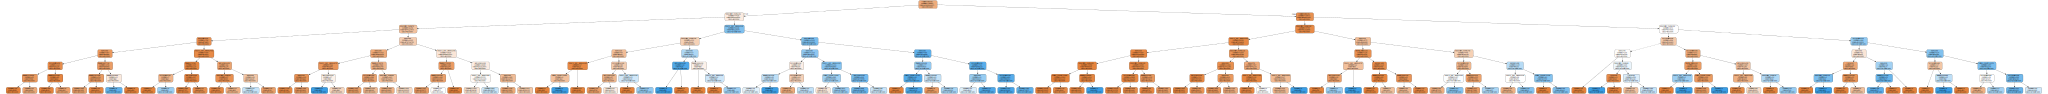

In [8]:
# Training classifiers
clf = DecisionTreeClassifier(max_depth=7)

clf.fit(X_train, y_train)
#tree.plot_tree(clf.fit(X_train, y_train))

import graphviz 

dot_data = tree.export_graphviz(clf, leaves_parallel = True, impurity=False, feature_names = X_raw.columns, class_names=['less 50K', 'greater 50K'], filled=True, rounded=True, special_characters=True, out_file=None) 
graph = graphviz.Source(dot_data) 
graph 

Look at the last decisions to see "unfairness" (people having same background but won't be paid similarly due to their last feature ('race', 'gender'...) 

## Bagging
Bagging is a portmanteau word for *bootstrap aggregating*.
The paradigm of bagging is to train independently several base classifiers $(g_1, \dots, g_T)$, with $g_t \colon \mathbb R^d \to \{\pm 1\}$, and to build a new classifier by averaging the predictions of the base classifiers:
$$
    g_n^T(x) = \operatorname{sign} \left( \frac{1}{T} \sum_{t=1}^T g_t(x) \right).
$$
Doing so, the variance of the prediction is reduced and so it is for the global error.
The requirements for such a result are:
- base classifiers should be more accurate than chance;
- base classifiers should be estimated independently from each other.

In practice, base classifiers are trained *quasi-independently* by bootstrapping the training set.

Bagging is also valid for multiclass problems: for $C$ classes, the prediction is:
$$
    g_n^T(x)
    = \operatorname{arg\,max}_{1 \le j \le C} \frac{1}{T} \sum_{t=1}^T g_t(x) \mathbb 1_{g_t(x)=j}
    = \operatorname{arg\,max}_{1 \le j \le C} \operatorname{card} \left( \left\{ t \in [T] : g_t(x) \mathbb 1_{g_t(x)=j} \right\} \right),
$$
where $g_t \colon \mathbb R^d \to [C]$, which corresponds to the majority vote since base classifiers are equally weighted.

Finally, one may also bag regressors $g_t \colon \mathbb R^d \to \mathbb R$ by a simple averaging:
$$
    g_n^T(x) = \frac{1}{T} \sum_{t=1}^T g_t(x).
$$

Assume that we are provided with a sequence of independent classifiers $(g_1, \dots, g_T)$, with $g_t \colon \mathbb R^d \to \{\pm 1\}$, such that classifiers are equally good: there exists $p>0.5$ such that $\mathbb P(g_t(X)=Y) = p$ for all $t \in [T]$.
We now consider the bagged classifier
$$
    g_n^T(x) = \operatorname{sign} \left( \frac{1}{T} \sum_{t=1}^T g_t(x) \right).
$$
What is the distribution of the random variable $\sum_{t=1}^T \mathbb 1_{g_t(X)=Y}$?
Plot its probability mass function for $T=9$ and $p=0.7$.

**Answer**

By independence of the classifiers, the random variable of interest is distributed accordingly to a binomial distribution with parameters T and p.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  import sys


<StemContainer object of 3 artists>

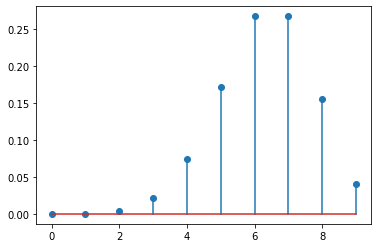

In [9]:
# Answer
from scipy.stats import binom

T, p = 9, 0.7
rv = binom(T, p)
pmf = rv.pmf(np.arange(T+1))

plt.stem(pmf)

For these particular values of $T$ and $p$, compute numerically $\mathbb P(g_n^T(X)=Y)$.

**Answer**

We have that $g_n^T(X)=Y$ if and only if the majority of base classifiers say that
$g_t(X)=Y$, that is if at least 5 of them say that.

In [10]:
# Answer
print("Probability of success of the bagged classifier:", pmf[T//2+1:].sum())

Probability of success of the bagged classifier: 0.9011913399999991


Plot the probability of success (or accuracy) with respect to the number of base classifiers for $p \in [0.55, 0.65, \dots, 0.95]$.
Be careful, the formula used previously is only valid for odd numbers of base classifiers.

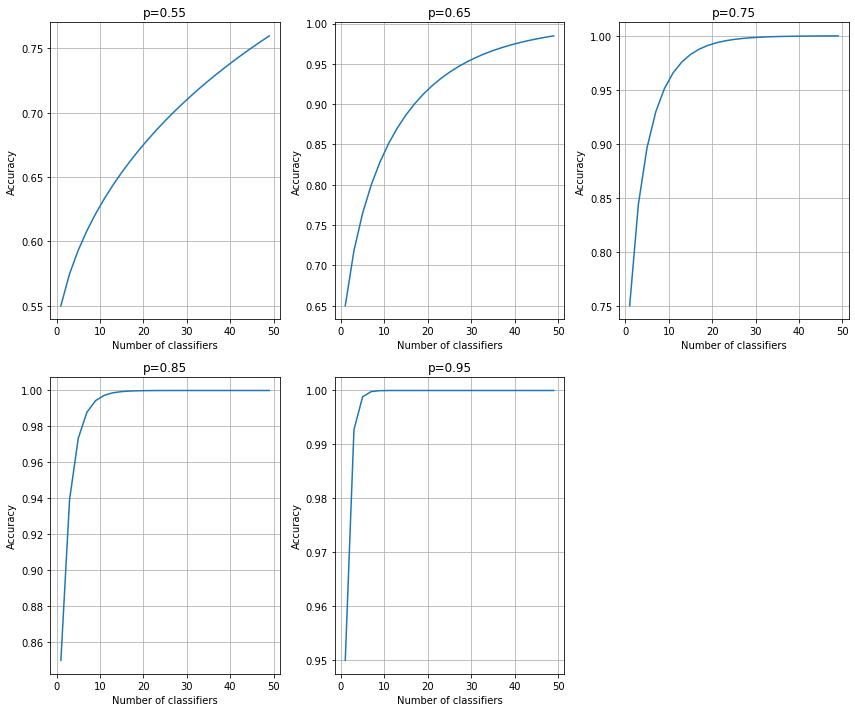

In [11]:
# Answer
Ts = np.arange(1, 50, step=2)

plt.figure(figsize=(12, 10))
for it, p in enumerate(np.arange(0.55, 1, step=0.1)):
    success = [binom.pmf(np.arange(T+1), T, p)[T//2+1:].sum() for T in Ts]
    plt.subplot(2, 3, it+1)
    plt.plot(Ts, success)
    plt.xlabel("Number of classifiers")
    plt.ylabel("Accuracy")
    plt.title("p={}".format(p))
    plt.grid()
plt.tight_layout()

Complete the following script to implement bagging with regression trees.

In [0]:
# Answer
from sklearn.tree import DecisionTreeRegressor
class BaggingTree(object):
    def __init__(self, n_estimators=10, max_depth=1, max_samples=1.0):
        """
        Parameters:
        - n_estimators: number of estimators
        - max_depth: maximal depth of the regressor tree
        - max_samples: ratio of samples to use for learning base regressors.
            - If max_samples=1.0: use bootstrap.
            - If max_samples<1.0: use random sampling and extract max_samples x n points
            (where n is the total numer of points).
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_samples = max_samples
        
    def fit(self, X, y):
        # Make X a 2d-array
        X = np.asarray(X)
        if X.ndim == 1:
            X = X[:, np.newaxis]
            
        n = X.shape[0]  # Sample size
        m = int(self.max_samples * n)  # Number of points for random sampling
        
        self.estimators_ = []
        for t in range(self.n_estimators):
            if self.max_samples==1:
                idx = np.random.randint(0, n, n)  # Bootstrap
            else:
                idx = np.random.permutation(n)[:m]  # Random sampling
            self.estimators_.append(DecisionTreeRegressor(max_depth=self.max_depth))
            self.estimators_[-1].fit(X[idx], y[idx])
    
    def predict(self, X):
        # Make X a 2d-array
        X = np.asarray(X)
        if X.ndim == 1:
            X = X[:, np.newaxis]
        
        y = [reg.predict(X) for reg in self.estimators_]
        return np.asarray(y).mean(axis=0)
    
    def error(self, X, y):
        # Make X a 2d-array
        X = np.asarray(X)
        if X.ndim == 1:
            X = X[:, np.newaxis]
        return np.sum((y - self.predict(X))**2)

Apply bagging to the following regression dataset and plot (on the same figure), the training data and the prediction for test data.

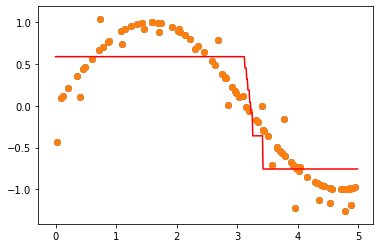

In [13]:
# Regression dataset
n = 100
X_train = np.sort(5 * np.random.rand(n))
y_train = np.sin(X_train)
y_train[::5] += 1 * (0.5 - np.random.rand(n//5))

X_test = np.arange(0, 5, step=1e-2)
y_test = np.sin(X_test)

# Make 2d-arrays
X_train = X_train[:, np.newaxis]
X_test = X_test[:, np.newaxis]

plt.scatter(X_train, y_train)

# Answer
reg = BaggingTree()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

plt.scatter(X_train, y_train)
plt.plot(X_test, y_pred, 'r')

Analyze the behavior of the prediction curve and of the test error with respect to the maximal depth of decision trees and to the number of base regressors.

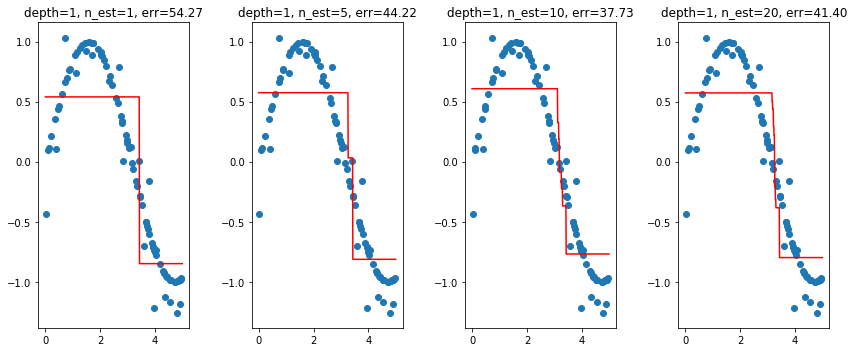

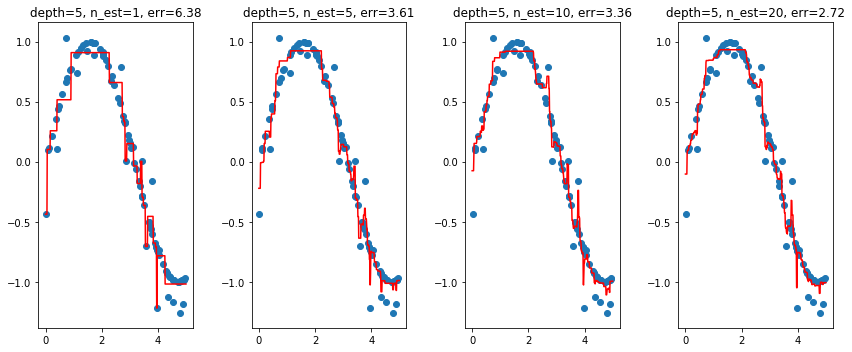

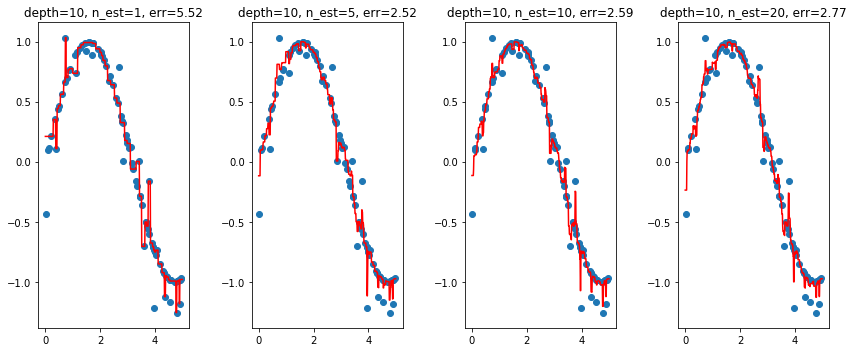

In [14]:
# Answer
for depth in [1, 5, 10]:
    plt.figure(figsize=(12, 5))
    for it, T in enumerate([1, 5, 10, 20]):
        reg = BaggingTree(n_estimators=T, max_depth=depth)
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)

        plt.subplot(1, 4, it+1)
        plt.scatter(X_train, y_train)
        plt.plot(X_test, y_pred, 'r')
        plt.title("depth={0}, n_est={1}, err={2:0.2f}".format(depth, T,
                                                              reg.error(X_test, y_test)))
    plt.tight_layout()

We consider decision trees with *max\_depth = 5*.
Plot two curves (one with bootstrap and one with 25%-subsampling) showing the test error with respect to the number of base regressors.
What can we conclude?

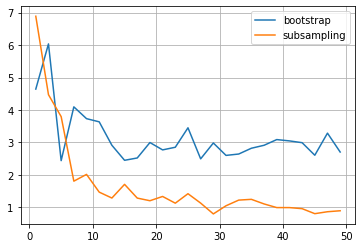

In [15]:
# Answer
depth = 5

estim = np.arange(1, 50, step=2)
for name, reg in [("bootstrap", BaggingTree(max_depth=depth, max_samples=1)),
                  ("subsampling", BaggingTree(max_depth=depth, max_samples=0.25))]:
    error = []
    for T in estim:
        reg.n_estimators = T
        reg.fit(X_train, y_train)
        error.append(reg.error(X_test, y_test))
    plt.plot(estim, error, label=name)
plt.legend(loc="best")
plt.grid()

## Random forests

Random forests are bagged trees: for binary classification, a random forest is
$$
    g_n^T(x) = \operatorname{sign} \left( \frac{1}{T} \sum_{t=1}^T g_t(x) \right),
$$
where the base classifiers $(g_1, \dots, g_T)$, with $g_t \colon \mathbb R^d \to \{\pm 1\}$, are learned quasi-independently by bootstrap.

However, in order to enforce the independent learning, each decision tree $g_t$ owns an additional randomization step in its learning procedure:

1. at each cell, select a subset of features at random;
1. find the best pair (feature, threshold) for splitting.

The following script loads and preprocesses the [diabetes dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html).
Explain each step and indicate its purpose.

Is it useful for decision trees?

In [0]:
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler

data = load_diabetes()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2)

scaler = StandardScaler() # not necessary here 
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = scaler.fit_transform(y_train.reshape(-1, 1))[:, 0]
y_test = scaler.transform(y_test.reshape(-1, 1))[:, 0]

On the [diabetes dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html), compare scikit-learn [bagging](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html) (with bootstrap and 25%-subsampling) and [random forests](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).
For this purpose, consider *max\_depth = 5* and plot three curves showing the regression score for the test set with respect to the number of base regressors.
What can we conclude?

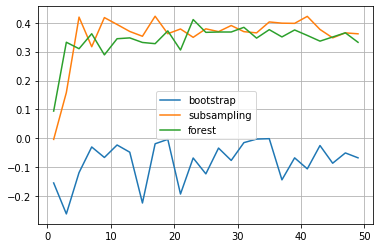

In [17]:
# Answer
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

depth = 5
params = {"max_depth": depth}

estim = np.arange(1, 50, step=2)
for name, reg in [("bootstrap", BaggingRegressor(base_estimator=DecisionTreeRegressor(**params),
                                                 max_samples=1)),
                  ("subsampling", BaggingRegressor(base_estimator=DecisionTreeRegressor(**params),
                                                   bootstrap=False,
                                                   max_samples=0.25)),
                  ("forest", RandomForestRegressor(**params))]:
    score = []
    for T in estim:
        reg.n_estimators = T
        reg.fit(X_train, y_train)
        score.append(reg.score(X_test, y_test))
    plt.plot(estim, score, label=name)
plt.legend(loc="best")
plt.grid()